In [7]:
!wget -O "dataset.zip" "https://data.mendeley.com/public-files/datasets/tywbtsjrjv/files/b4e3a32f-c0bd-4060-81e9-6144231f2520/file_downloaded"

--2025-09-13 16:23:26--  https://data.mendeley.com/public-files/datasets/tywbtsjrjv/files/b4e3a32f-c0bd-4060-81e9-6144231f2520/file_downloaded
Resolving data.mendeley.com (data.mendeley.com)... 162.159.133.86, 162.159.130.86
Connecting to data.mendeley.com (data.mendeley.com)|162.159.133.86|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://prod-dcd-datasets-public-files-eu-west-1.s3.eu-west-1.amazonaws.com/349ac012-2948-4172-bbba-3bf8f76596fd [following]
--2025-09-13 16:23:27--  https://prod-dcd-datasets-public-files-eu-west-1.s3.eu-west-1.amazonaws.com/349ac012-2948-4172-bbba-3bf8f76596fd
Resolving prod-dcd-datasets-public-files-eu-west-1.s3.eu-west-1.amazonaws.com (prod-dcd-datasets-public-files-eu-west-1.s3.eu-west-1.amazonaws.com)... 3.5.70.121, 52.218.116.66, 52.92.16.242, ...
Connecting to prod-dcd-datasets-public-files-eu-west-1.s3.eu-west-1.amazonaws.com (prod-dcd-datasets-public-files-eu-west-1.s3.eu-west-1.amazonaws.com)|3.5.70.121|:443...

In [9]:
!unzip /content/dataset.zip

Archive:  /content/dataset.zip
replace Plant_leave_diseases_dataset_with_augmentation/Apple___Apple_scab/image (1).JPG? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

In [12]:
!pip install split-folders

In [13]:
import splitfolders
splitfolders.ratio('/content/Plant_leave_diseases_dataset_with_augmentation', output="dataset", seed=1337, ratio=(.8,.1,.1))


Copying files: 61486 files [00:10, 5662.83 files/s]


Data preprocessing


In [14]:
train_dir = "/content/dataset/train"
validation_dir = "/content/dataset/val"

BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

Found 49179 files belonging to 39 classes.


In [15]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

test_dir = "/content/dataset/test"
test_dataset = tf.keras.utils.image_dataset_from_directory(test_dir,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 6139 files belonging to 39 classes.
Found 6168 files belonging to 39 classes.


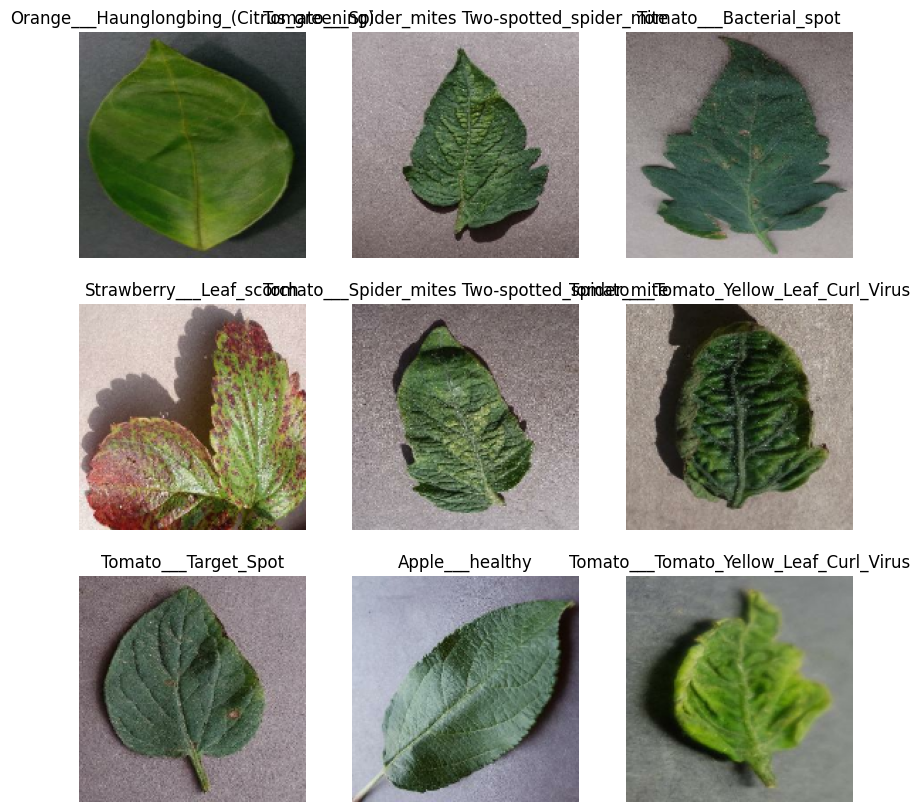

In [16]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [17]:
class_names

['Apple___Apple_scab',
 'Apple___Black_rot',
 'Apple___Cedar_apple_rust',
 'Apple___healthy',
 'Background_without_leaves',
 'Blueberry___healthy',
 'Cherry___Powdery_mildew',
 'Cherry___healthy',
 'Corn___Cercospora_leaf_spot Gray_leaf_spot',
 'Corn___Common_rust',
 'Corn___Northern_Leaf_Blight',
 'Corn___healthy',
 'Grape___Black_rot',
 'Grape___Esca_(Black_Measles)',
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
 'Grape___healthy',
 'Orange___Haunglongbing_(Citrus_greening)',
 'Peach___Bacterial_spot',
 'Peach___healthy',
 'Pepper,_bell___Bacterial_spot',
 'Pepper,_bell___healthy',
 'Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___healthy',
 'Raspberry___healthy',
 'Soybean___healthy',
 'Squash___Powdery_mildew',
 'Strawberry___Leaf_scorch',
 'Strawberry___healthy',
 'Tomato___Bacterial_spot',
 'Tomato___Early_blight',
 'Tomato___Late_blight',
 'Tomato___Leaf_Mold',
 'Tomato___Septoria_leaf_spot',
 'Tomato___Spider_mites Two-spotted_spider_mite',
 'Tomato___Target_Spot'

In [18]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [19]:
preprocess_input = tf.keras.applications.efficientnet.preprocess_input

# **Create the base model from the pre-trained convnets**

In [20]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.EfficientNetB4(
    input_shape=IMG_SHAPE,
    include_top=False,
    weights='imagenet',
)

71686520/71686520 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [21]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1792)


Feature extraction

In [22]:
base_model.trainable = False

In [23]:
base_model.summary()

Model: "efficientnetb4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 160, 160,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 160, 160,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 160, 160,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 160, 160,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 161, 161,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 80, 80,    │      1,296 │ stem_conv_pad[0]… │
│                     │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 80, 80,    │        192 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 80, 80,    │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 80, 80,    │        432 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 80, 80,    │        192 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 80, 80,    │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 48)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 48)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 12)  │        588 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 48)  │        624 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 80, 80,    │          0 │ block1a_activati… │
│ (Multiply)          │ 48)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 80, 80,    │      1,152 │ block1a_se_excit

 Total params: 17,673,823 (67.42 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 17,673,823 (67.42 MB)

In [24]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1792)


In [26]:
prediction_layer = tf.keras.layers.Dense(len(class_names), activation='sigmoid')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 39)


In [27]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [28]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb4 (Functional)     │ (None, 5, 5, 1792)     │    17,673,823 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1792)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1792)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 39)             │        69,927 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,743,750 (67.69 MB)

 Trainable params: 69,927 (273.15 KB)

 Non-trainable params: 17,673,823 (67.42 MB)

In [29]:
len(model.trainable_variables)

2

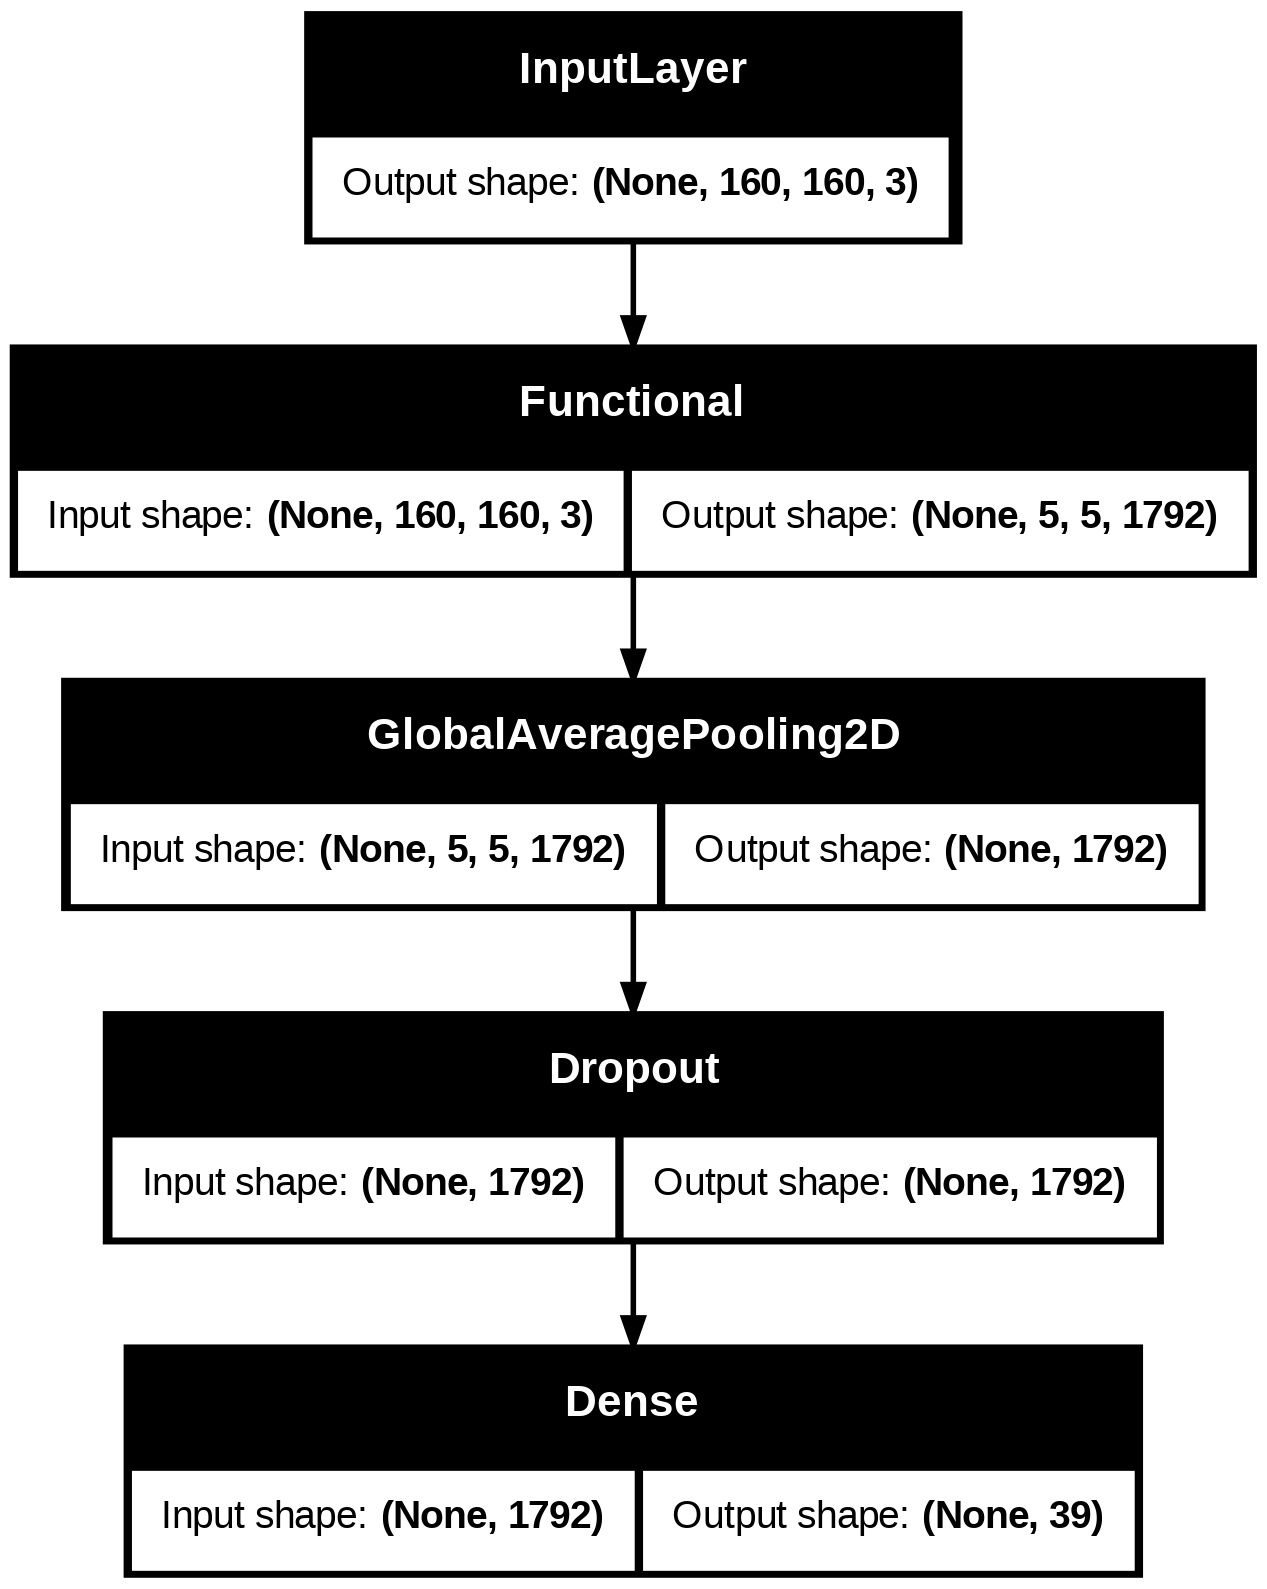

In [30]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [31]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy( name='accuracy')])

In [32]:
initial_epochs = 6

loss0, accuracy0 = model.evaluate(validation_dataset)

192/192 ━━━━━━━━━━━━━━━━━━━━ 46s 131ms/step - accuracy: 0.0167 - loss: 3.7616


In [33]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 3.77
initial accuracy: 0.02


In [34]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/6
1537/1537 ━━━━━━━━━━━━━━━━━━━━ 152s 71ms/step - accuracy: 0.7048 - loss: 1.1926 - val_accuracy: 0.9148 - val_loss: 0.3123
Epoch 2/6
1537/1537 ━━━━━━━━━━━━━━━━━━━━ 98s 58ms/step - accuracy: 0.9047 - loss: 0.3431 - val_accuracy: 0.9348 - val_loss: 0.2259
Epoch 3/6
1537/1537 ━━━━━━━━━━━━━━━━━━━━ 88s 57ms/step - accuracy: 0.9207 - loss: 0.2660 - val_accuracy: 0.9422 - val_loss: 0.1902
Epoch 4/6
1537/1537 ━━━━━━━━━━━━━━━━━━━━ 142s 58ms/step - accuracy: 0.9307 - loss: 0.2277 - val_accuracy: 0.9456 - val_loss: 0.1683
Epoch 5/6
1537/1537 ━━━━━━━━━━━━━━━━━━━━ 142s 57ms/step - accuracy: 0.9360 - loss: 0.2065 - val_accuracy: 0.9519 - val_loss: 0.1532
Epoch 6/6
1537/1537 ━━━━━━━━━━━━━━━━━━━━ 142s 58ms/step - accuracy: 0.9407 - loss: 0.1896 - val_accuracy: 0.9493 - val_loss: 0.1541


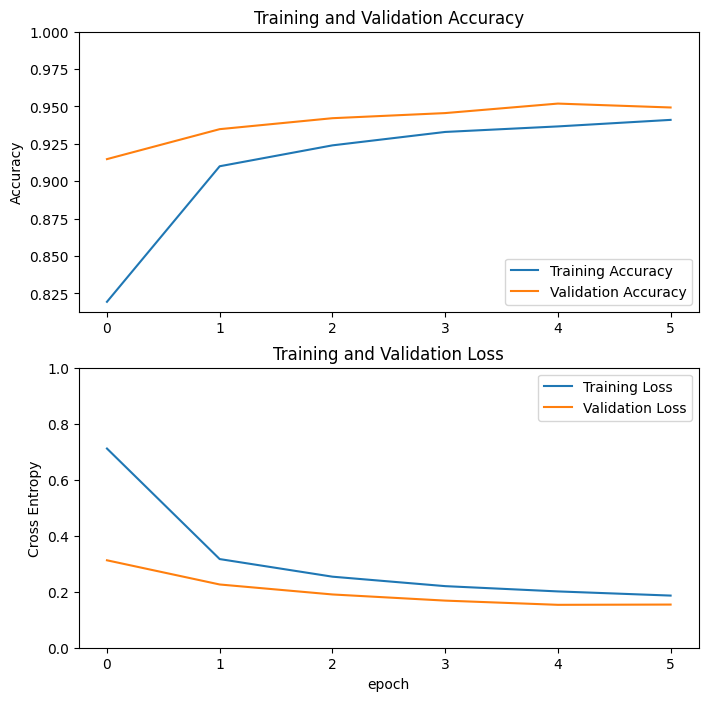

In [35]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# **Fine tuning**

In [36]:
base_model.trainable = True

In [37]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  475


In [38]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy( name='accuracy')])

In [39]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb4 (Functional)     │ (None, 5, 5, 1792)     │    17,673,823 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1792)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1792)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 39)             │        69,927 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,743,750 (67.69 MB)

 Trainable params: 17,531,783 (66.88 MB)

 Non-trainable params: 211,967 (828.00 KB)

In [40]:
len(model.trainable_variables)

333

In [41]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=len(history.epoch),
                         validation_data=validation_dataset)

Epoch 7/16
1537/1537 ━━━━━━━━━━━━━━━━━━━━ 439s 209ms/step - accuracy: 0.8856 - loss: 0.4134 - val_accuracy: 0.9677 - val_loss: 0.1022
Epoch 8/16
1537/1537 ━━━━━━━━━━━━━━━━━━━━ 236s 153ms/step - accuracy: 0.9641 - loss: 0.0994 - val_accuracy: 0.9695 - val_loss: 0.0979
Epoch 9/16
1537/1537 ━━━━━━━━━━━━━━━━━━━━ 260s 152ms/step - accuracy: 0.9698 - loss: 0.0704 - val_accuracy: 0.9471 - val_loss: 0.1042
Epoch 10/16
1537/1537 ━━━━━━━━━━━━━━━━━━━━ 262s 152ms/step - accuracy: 0.9717 - loss: 0.0546 - val_accuracy: 0.9448 - val_loss: 0.0452
Epoch 11/16
1537/1537 ━━━━━━━━━━━━━━━━━━━━ 262s 152ms/step - accuracy: 0.9706 - loss: 0.0577 - val_accuracy: 0.9510 - val_loss: 0.0830
Epoch 12/16
1537/1537 ━━━━━━━━━━━━━━━━━━━━ 266s 154ms/step - accuracy: 0.9724 - loss: 0.0513 - val_accuracy: 0.9114 - val_loss: 0.1030
Epoch 13/16
1537/1537 ━━━━━━━━━━━━━━━━━━━━ 262s 154ms/step - accuracy: 0.9722 - loss: 0.0384 - val_accuracy: 0.9550 - val_loss: 0.0738
Epoch 14/16
1537/1537 ━━━━━━━━━━━━━━━━━━━━ 260s 153ms/step

In [42]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

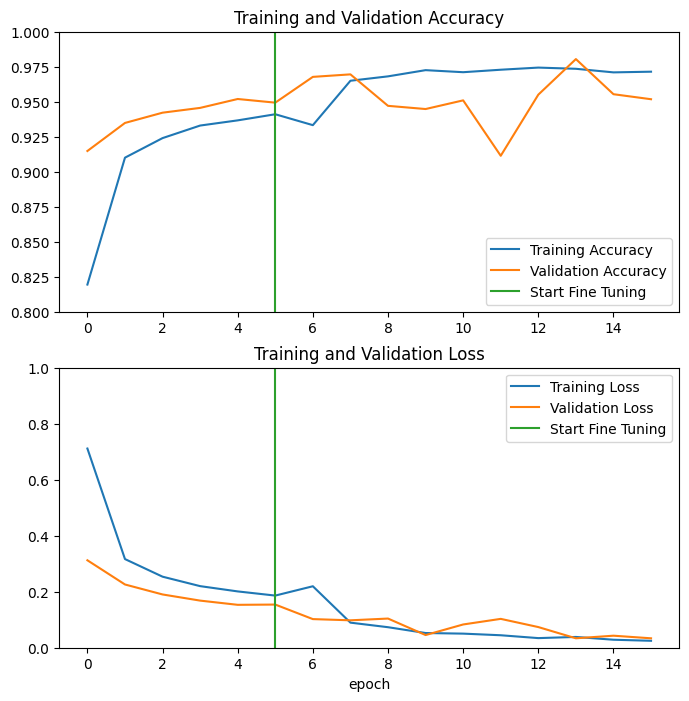

In [43]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [44]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

193/193 ━━━━━━━━━━━━━━━━━━━━ 25s 131ms/step - accuracy: 0.9438 - loss: 0.0345
Test accuracy : 0.9471465349197388


Predictions:
 [24 17  9 25 18 16 21 38 30 18 26 36 27 26 28 25  2 16 30 38 33 16  7 16
 10  1 26 16  7 29  3 17]
Labels:
 [24 19  9 25 18 16 21 38 30 18 26 36 27 26 28 25  2 16 30 38 33 16 11 16
 10  1 26 16  7 29  3 17]


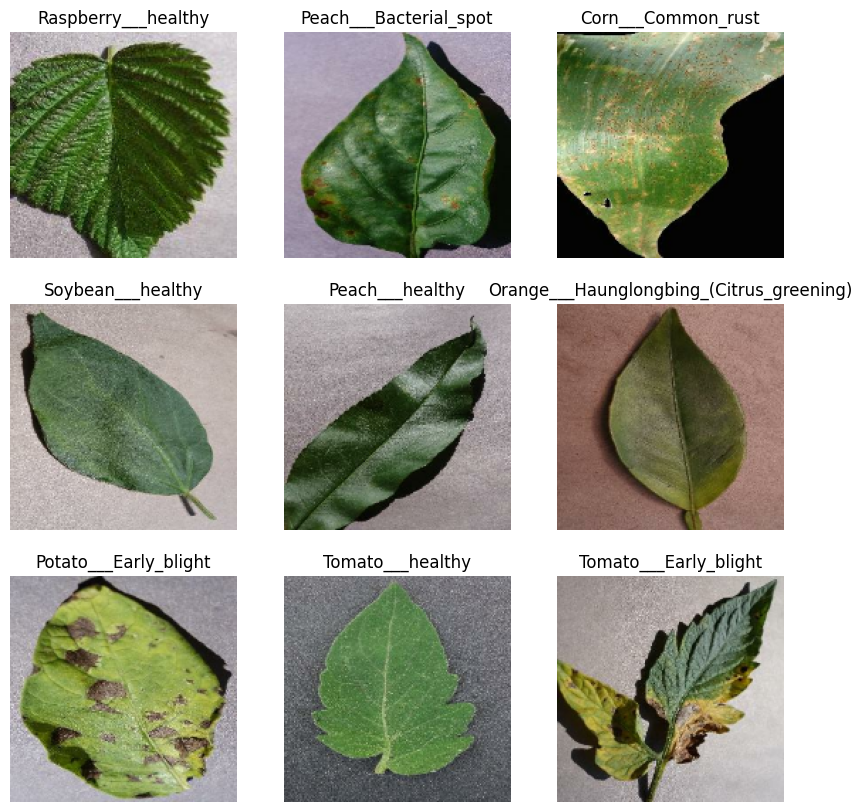

In [45]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)
predictions = tf.argmax(predictions,axis =1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

**saving model**

In [46]:
model.save("plant_disease_recog_model_pwp.keras")